<a href="https://colab.research.google.com/github/hectorLop/Waste-Detector/blob/main/Waste_Detector_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import pandas as pd
import collections
import os
import torch
import gc

from PIL import Image, ExifTags
from matplotlib.patches import Rectangle, Polygon
from sklearn.model_selection import train_test_split

In [2]:
from PIL import Image, ExifTags, ImageDraw
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

In [3]:
!pip install albumentations -U

     |████████████████████████████████| 102 kB 5.5 MB/s 
     |████████████████████████████████| 47.6 MB 160 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Data Exploration
Let's take a look at the `train.json` file. It contains all the information using the COCO format.

In [4]:
with open('/content/drive/MyDrive/Proyectos/Waste-Detector/taco-dataset/annotations.json', 'r') as file:
    annotations = json.load(file)

In [5]:
annotations.keys()

dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])

In [6]:
categories_df = pd.DataFrame(annotations['categories'])
images_df = pd.DataFrame(annotations['images'])
annotations_df = pd.DataFrame(annotations['annotations'])

In [7]:
images_df

,id,width,height,file_name,license,flickr_url,coco_url,date_captured,flickr_640_url
0,0,1537,2049,batch_1/000006.jpg,None,https://farm66.staticflickr.com/65535/33978196...,None,None,https://farm66.staticflickr.com/65535/33978196...
1,1,1537,2049,batch_1/000008.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
2,2,1537,2049,batch_1/000010.jpg,None,https://farm66.staticflickr.com/65535/40888872...,None,None,https://farm66.staticflickr.com/65535/40888872...
3,3,2049,1537,batch_1/000019.jpg,None,https://farm66.staticflickr.com/65535/47803331...,None,None,https://farm66.staticflickr.com/65535/47803331...
4,4,1537,2049,batch_1/000026.jpg,None,https://farm66.staticflickr.com/65535/33978199...,None,None,https://farm66.staticflickr.com/65535/33978199...
...,...,...,...,...,...,...,...,...,...
1495,1495,1824,4000,batch_9/000095.jpg,CC,https://farm66.staticflickr.com/65535/48701319...,None,None,https://farm66.staticflickr.com/65535/48701319...
1496,1496,1824,4000,batch_9/000096.jpg,CC,https://farm66.staticflickr.com/65535/48701319...,None,None,https://farm66.staticflickr.com/65535/48701319...
1497,1497,4000,1824,batch_9/000097.jpg,CC,https://farm66.staticflickr.com/65535/48694319...,None,None,https://farm66.staticflickr.com/65535/48694319...
1498,1498,1824,4000,batch_9/000098.jpg,CC,https://farm66.staticflickr.com/65535/48693804...,None,None,https://farm66.staticflickr.com/65535/48693804...


In [8]:
data = []

for id in annotations_df['image_id']:
    image_data = images_df[images_df['id'] == id]
    
    file_name = image_data['file_name'].values[0]
    width= image_data['width'].values[0]
    height = image_data['height'].values[0]

    data.append((file_name, width, height))

In [9]:
df = pd.DataFrame(data, columns=['filename', 'width', 'height'])
annotations_df = pd.concat([annotations_df, df], axis=1)

In [10]:
annotations_df

,id,image_id,category_id,segmentation,area,bbox,iscrowd,filename,width,height
0,1,0,6,"[[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0,...",4.039540e+05,"[517.0, 127.0, 447.0, 1322.0]",0,batch_1/000006.jpg,1537,2049
1,2,1,18,"[[928.0, 1876.0, 938.0, 1856.0, 968.0, 1826.0,...",1.071260e+06,"[1.0, 457.0, 1429.0, 1519.0]",0,batch_1/000008.jpg,1537,2049
2,3,1,14,"[[617.0, 383.0, 703.0, 437.0, 713.0, 456.0, 72...",9.958350e+04,"[531.0, 292.0, 1006.0, 672.0]",0,batch_1/000008.jpg,1537,2049
3,4,2,5,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",7.383250e+04,"[632.0, 987.0, 500.0, 374.0]",0,batch_1/000010.jpg,1537,2049
4,5,2,7,"[[647.0, 1028.0, 650.0, 1022.0, 653.0, 1016.0,...",9.150000e+02,"[632.0, 989.0, 44.0, 51.0]",0,batch_1/000010.jpg,1537,2049
...,...,...,...,...,...,...,...,...,...,...
4779,4779,1498,16,"[[386, 1557, 635, 1567, 986, 1556, 1178, 1550,...",5.032469e+05,"[228.7143, 1550.0476, 1007.9998999999999, 578....",0,batch_9/000098.jpg,1824,4000
4780,4780,1498,7,"[[1057, 1824, 1041, 1793, 1042, 1758, 1062, 17...",1.449450e+04,"[1041.3334, 1721.7142, 141.0, 138.0]",0,batch_9/000098.jpg,1824,4000
4781,4781,1499,39,"[[1368, 1775, 1099, 1331, 862, 1494, 1099, 1944]]",1.549541e+05,"[862.0274, 1331.25, 505.97260000000006, 612.5]",0,batch_9/000099.jpg,1824,4000
4782,4782,1499,14,"[[1096, 1996, 1121, 2069, 1134, 2127, 1177, 22...",2.867500e+04,"[966.0, 1996.0, 211.0, 336.0]",0,batch_9/000099.jpg,1824,4000


In [12]:
class Config:
    IMGS_PATH = '/content/drive/MyDrive/Proyectos/Waste-Detector/taco-dataset/'
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    BATCH_SIZE=8
    EPOCHS = 30
    LEARNING_RATE = 0.005
    WEIGHT_DECAY = 0.0005

In [13]:
categories_df.head()

,supercategory,id,name
0,Aluminium foil,0,Aluminium foil
1,Battery,1,Battery
2,Blister pack,2,Aluminium blister pack
3,Blister pack,3,Carded blister pack
4,Bottle,4,Other plastic bottle


In [ ]:
def get_img(filepath, annotations_df, config = Config):
    #Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    img_id = annotations_df[annotations_df['filename'] == filepath]['image_id'].values[0]
    I = Image.open(config.IMGS_PATH + filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    return I, img_id

def plot_img(img, annotations_df, img_id):
    df = annotations_df[annotations_df['image_id'] == img_id]

    # Show image
    fig,ax = plt.subplots(1)
    plt.imshow(img)

    for row in df.iterrows():
        data = row[1]
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        for seg in data['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)

        [x, y, w, h] = data['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

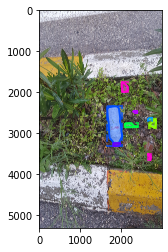

In [ ]:
I, img_id = get_img(annotations_df.iloc[900, :]['filename'], annotations_df)
plot_img(I, annotations_df, img_id)

## Group Categories
In this section we are going to group the actual categories into the desired ones:
- plastic 
- carton
- rest
- glass
- other
- organic
- dangerous

In [14]:
replacements = {
    'Foam food container': 'plastic',
    'Squeezable tube': 'plastic',
    'Metal lid': 'plastic',
    'Egg carton': 'carton',
    'Spread tub': 'plastic',
    'Paper bag': 'plastic',
    'Normal paper': 'carton',
    'Tissues': 'rest',
    'Plastic straw': 'plastic',
    'Single-use carrier bag': 'plastic',
    'Scrap metal': 'other',
    'Crisp packet': 'plastic',
    'Styrofoam piece': 'carton',
    'Glass bottle': 'glass',
    'Drink can': 'plastic',
    'Other plastic cup': 'plastic',
    'Battery': 'dangerous',
    'Paper cup': 'carton',
    'Polypropylene bag': 'plastic',
    'Rope & strings': 'rest',
    'Food Can': 'plastic',
    'Plastic lid': 'plastic',
    'Wrapping paper': 'carton',
    'Clear plastic bottle': 'plastic',
    'Other plastic wrapper': 'plastic',
    'Carded blister pack': 'carton',
    'Corrugated carton': 'carton',
    'Foam cup': 'plastic',
    'Magazine paper': 'carton',
    'Broken glass': 'glass',
    'Paper straw': 'carton',
    'Other plastic bottle': 'plastic',
    'Metal bottle cap': 'glass',
    'Unlabelled litter': 'other',
    'Garbage bag': 'rest',
    'Plastic bottle cap': 'plastic',
    'Shoe': 'rest',
    'Other plastic': 'plastic',
    'Plastified paper bag': 'plastic',
    'Tupperware': 'plastic',
    'Plastic glooves': 'plastic',
    'Six pack rings': 'plastic',
    'Glass cup': 'glass',
    'Disposable plastic cup': 'plastic',
    'Plastic film': 'plastic',
    'Pizza box': 'carton',
    'Meal carton': 'carton',
    'Plastic utensils': 'plastic',
    'Disposable food container': 'plastic',
    'Cigarette': 'rest',
    'Food waste': 'organic',
    'Other carton': 'carton',
    'Glass jar': 'glass',
    'Toilet tube': 'carton',
    'Other plastic container': 'plastic',
    'Pop tab': 'plastic',
    'Aluminium blister pack': 'plastic',
    'Aerosol': 'plastic',
    'Aluminium foil': 'plastic',
    'Drink carton': 'carton',
    'Unlabeled litter': 'other'
}

In [15]:
categories_df['new_cat'] = categories_df['name'].replace(replacements)
categories_df.head()

,supercategory,id,name,new_cat
0,Aluminium foil,0,Aluminium foil,plastic
1,Battery,1,Battery,dangerous
2,Blister pack,2,Aluminium blister pack,plastic
3,Blister pack,3,Carded blister pack,carton
4,Bottle,4,Other plastic bottle,plastic


In [16]:
categories_df['new_cat'].value_counts()

plastic      32
carton       14
rest          5
glass         5
other         2
dangerous     1
organic       1
Name: new_cat, dtype: int64

In [17]:
new_categories = {}

for idx, cat in enumerate(pd.unique(categories_df['new_cat'])):
    if cat not in new_categories:
        new_categories[cat] = idx

new_categories

{'carton': 2,
 'dangerous': 1,
 'glass': 3,
 'organic': 4,
 'other': 6,
 'plastic': 0,
 'rest': 5}

In [18]:
categories_replacements = {}

for cat in new_categories:
    old_categories = categories_df[categories_df['new_cat'] == cat]['id']

    for old_cat in old_categories:
        if old_cat not in categories_replacements:
            categories_replacements[old_cat] = new_categories[cat]

In [19]:
annotations_df['category_id'] = annotations_df['category_id'].replace(categories_replacements)
annotations_df['category_id'].value_counts()

0    2586
5     776
2     541
6     537
3     334
4       8
1       2
Name: category_id, dtype: int64

Both the category 1 (dangerous) and 4 (organic) are heavily underrepresented in the dataset. That means the algorithm will not be able to recognize them.

# Experimentation

In [30]:
import torch
import torchvision
import albumentations as A

from albumentations.core.transforms_interface import ImageOnlyTransform
#from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

In [22]:
def fix_all_seeds(seed : int = 4496) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
fix_all_seeds(2022)

## Dataset

In [188]:
def read_img(filepath):
    #Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

    I = Image.open(filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180, expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270, expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90, expand=True)

    return np.array(I)

class CustomNormalization(A.ImageOnlyTransform):
    def _norm(self, img):
        return img / 255.

    def apply(self, img, **params):
        return self._norm(img)

def get_transforms(augment : bool = False):
    transforms = [
                  A.Resize(512, 512, interpolation=cv2.INTER_NEAREST),
                  CustomNormalization(p=1),
                #   A.Normalize(
                #       mean=(0.485, 0.456, 0.406),
                #       std=(0.229, 0.224, 0.225)
                #   ),
                  ]
    if augment:
        pass

    return transforms

class WasteImageDataset(Dataset):
    def __init__(self, df, transforms, config):
        self.df = df
        self.transforms = transforms
        self.config = config

        cols = [col for col in df.columns if col not in ['image_id', 'polygons']]
        self.temp_df = self.df.groupby(['image_id'])[cols].agg(lambda x: list(x)).reset_index()
        
        self.image_info = collections.defaultdict(dict)

        for index, row in self.temp_df.iterrows():
            self.image_info[index] = {
                'image_id': np.unique(row['image_id'])[0],
                'height': np.unique(row['height'])[0],
                'width': np.unique(row['width'])[0],
                'area': list(row['area']),
                'iscrowd': list(row['iscrowd']),
                'image_path': os.path.join(self.config.IMGS_PATH, row['filename'][0]),
                'bboxes': list(row['bbox']),
                'polygons': list(row['segmentation']), 
                'categories': list(row['category_id']),
            }

    def _generate_mask(self, height, width, seg):
        mask = np.zeros((height, width), dtype=np.uint8)

        polygon_shape = (int((len(seg) / 2)), 2)
        poly = np.array(seg).reshape(polygon_shape).astype(int)
        cv2.fillConvexPoly(mask, poly, 1)

        return mask
    
    def __getitem__(self, idx):
        info = self.image_info[idx]

        #print(info['image_path'])
        # Read the image and rotate it if neccesary
        img = read_img(info['image_path'])
        n_objects = len(info['bboxes'])
        
        # In PyTorch images are represented (channels, height, width)
        shape = (len(info['bboxes']), info['height'], info['width'])
        masks = np.zeros(shape, dtype=np.uint8)

        if img.shape[0] != info['height']:
            raise ValueError('The first dimmension of the image must be the height')

        for i, seg in enumerate(info['polygons']):
            # Seg is a list of lists so we must access the first element
            a_mask = self._generate_mask(info['height'], info['width'], seg[0])
            a_mask = np.array(a_mask) > 0

            masks[i, :, :] = a_mask

        boxes = [np.abs(box) for box in info['bboxes']]
        labels = info['categories']

        if self.transforms:
            augs = A.Compose(self.transforms,
                             bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
            try:
                transformed = augs(image=img,
                                masks=list(masks), # This parameter only accepts a list
                                bboxes=boxes,
                                class_labels=labels)
            except:
                print(boxes)
                raise ValueError('El problema es la normalizacion')

            img = transformed['image']
            masks = transformed['masks']
            boxes = transformed['bboxes']

        # Put the channels first, the image is already rotated in format (height, width)
        img = torch.from_numpy(img.transpose(2,0,1)) # channels first

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        try:
            boxes = torchvision.ops.box_convert(boxes, 'xywh', 'xyxy')
        except:
            print(boxes)
            raise ValueError('En fin serafin')

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.Tensor(info['image_id']),
            'area': torch.Tensor(info['area']),
            'iscrowd': torch.Tensor(info['iscrowd']),
        }

        return img, target

    def __len__(self):
        return len(self.image_info)

class WasteImageDatasetNoMask(Dataset):
    def __init__(self, df, transforms, config):
        self.df = df
        self.transforms = transforms
        self.config = config

        cols = [col for col in df.columns if col != 'image_id']
        self.temp_df = self.df.groupby(['image_id'])[cols].agg(lambda x: list(x)).reset_index()
        
        self.image_info = collections.defaultdict(dict)

        for index, row in self.temp_df.iterrows():
            self.image_info[index] = {
                'image_id': np.unique(row['image_id'])[0],
                'height': np.unique(row['height'])[0],
                'width': np.unique(row['width'])[0],
                'area': list(row['area']),
                'iscrowd': list(row['iscrowd']),
                'image_path': os.path.join(self.config.IMGS_PATH, row['filename'][0]),
                'bboxes': list(row['bbox']),
                'categories': list(row['category_id']),
            }
    
    def __getitem__(self, idx):
        info = self.image_info[idx]

        # Read the image and rotate it if neccesary
        img = read_img(info['image_path'])
        n_objects = len(info['bboxes'])

        if img.shape[0] != info['height']:
            raise ValueError('The first dimmension of the image must be the height')

        boxes = [np.abs(box) for box in info['bboxes']]
        labels = info['categories']

        if self.transforms:
            augs = A.Compose(self.transforms,
                             bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))
            transformed = augs(image=img,
                               bboxes=boxes,
                               class_labels=labels)

            img = transformed['image']
            boxes = transformed['bboxes']

        image_id = torch.tensor([info['image_id']])
        # Put the channels first, the image is already rotated in format (height, width)
        img = torch.from_numpy(img.transpose(2,0,1)) # channels first

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        boxes = torchvision.ops.box_convert(boxes, 'xywh', 'xyxy')

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.Tensor(info['image_id']),
            'area': torch.Tensor(info['area']),
            'iscrowd': torch.Tensor(info['iscrowd']),
        }

        return img, target

    def __len__(self):
        return len(self.image_info)



In [189]:
dataset = WasteImageDatasetNoMask(annotations_df, get_transforms(), Config)
loader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=lambda x: tuple(zip(*x)))

In [190]:
for tup in loader:
    a = tup
    break

In [58]:
colors = {
    0: ('plastic', 'yellow'),
    1: ('dangerous', 'red'),
    2: ('carton', 'blue'),
    3: ('glass', 'green'),
    4: ('organic', 'brown'),
    5: ('rest', 'black'),
    6: ('other', 'purple'),
}

In [137]:
def plot_img(img, boxes, polygons, categories, colors):
    # Show image
    fig,ax = plt.subplots(1)

    # Remember Pytorch uses (height, width) so we must transpose the image
    image = torch.transpose(img, 0, 2)
    image = torch.transpose(image, 0, 1)

    plt.imshow(image)

    for i, (box, polygon) in enumerate(zip(boxes, polygons)):
        color = colors[categories[i]][1]
        # Traspose due to the mask was (height, width)
        polygon = np.transpose(polygon).squeeze()
        poly = np.column_stack(np.where(polygon > 0))
        print(poly.shape)
        poly = Polygon(poly)
        p = PatchCollection([poly], facecolor=color, edgecolors='none',linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2, alpha=0.4)
        ax.add_collection(p)
            
        [x, y, w, h] = box
        rect = Rectangle((x,y),w,h,linewidth=4, edgecolor=color,
                         facecolor='none', alpha=0.7)
        ax.add_patch(rect)

    plt.show()

def plot_img_no_mask(img, boxes, categories, colors):
    # Show image
    
    # Remember Pytorch uses (height, width) so we must transpose the image
    image = torch.transpose(img, 0, 2)
    image = torch.transpose(image, 0, 1)

    boxes = boxes.cpu().numpy().astype(np.int32)
    image = image.cpu().numpy()

    fig,ax = plt.subplots(1, 1, figsize=(12, 6))

    for i, box in enumerate(boxes):
        color = colors[categories[i].item()][1]
            
        [x1, y1, x2, y2] = np.array(box).astype(int)
        image = np.array(image)

        cv2.rectangle(image, (x1, y1), 
                      (x2, y2), (220,0,0), 3)

    ax.imshow(image)
    plt.show()

(131, 160)
(316, 358)


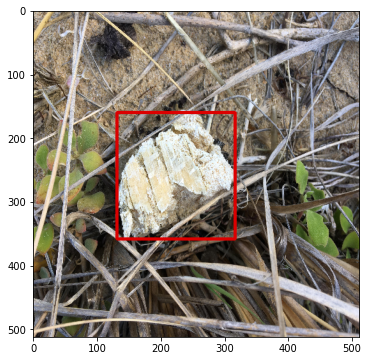

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(130, 259)
(204, 321)


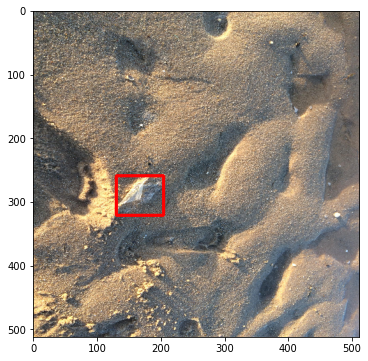

In [138]:
for i in range(len(a[0])):
    plot_img_no_mask(a[0][i], a[1][i]['boxes'], a[1][i]['labels'], colors)
    plt.show()

#### IMPORTANT
The images look different (more contrasted) because of the normalization step. Besides, some generated polygons have incorrect shapes.

In [139]:
#cols = [col for col in df.columns if col != 'image_id']
#df_images = self.df.groupby(['image_id', 'category_id'])[cols].agg(lambda x: list(x)).reset_index()
df_images = annotations_df.groupby(['image_id']).agg({'category_id': 'count'}).sort_values('category_id', ascending=False).reset_index()

In [140]:
df_images

,image_id,category_id
0,1107,90
1,1321,54
2,362,38
3,426,37
4,363,37
...,...,...
1495,898,1
1496,899,1
1497,900,1
1498,901,1


In [141]:
# Use the quantiles of amount of annotations to stratify
df_images_train, df_images_test = train_test_split(df_images,
                                                   #stratify=df_images['bbox'],
                                                   test_size=0.2,
                                                   random_state=42)

# Use the quantiles of amount of annotations to stratify
df_images_train, df_images_val = train_test_split(df_images_train,
                                                  #stratify=df_images_train['bbox'],
                                                  test_size=0.2,
                                                  random_state=2021)

# df_images solo posee el id, cell types y numero de anotaciones
df_train = annotations_df[annotations_df['image_id'].isin(df_images_train['image_id'])]
df_val = annotations_df[annotations_df['image_id'].isin(df_images_val['image_id'])]
df_test = annotations_df[annotations_df['image_id'].isin(df_images_test['image_id'])]

print(f"Images in train set:           {len(df_images_train)}")
print(f"Annotations in train set:      {len(df_train)}")
print(f"Images in validation set:      {len(df_images_val)}")
print(f"Annotations in validation set: {len(df_val)}")
print(f"Images in test set:      {len(df_images_test)}")
print(f"Annotations in test set: {len(df_test)}")

Images in train set:           960
Annotations in train set:      3167
Images in validation set:      240
Annotations in validation set: 751
Images in test set:      300
Annotations in test set: 866


## Model

In [142]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [151]:
def get_model(num_classes=7, model_chkpt=None, config=Config):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                box_detections_per_img=60,
                                                                image_mean=(0.485, 0.456, 0.406),
                                                                image_std=(0.229, 0.224, 0.225))
        
    # Number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
    
    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                      hidden_layer,
                                                      num_classes+1)
        
    return model

def get_faster_rcnn(num_classes, config=Config):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [200]:
def train_step(model, train_loader, config, scheduler, optimizer, n_batches):
    #model.train()

    loss_accum = 0.0
    #loss_mask_accum = 0.0
    #loss_classifier_accum = 0.0

    for batch_idx, (images, targets) in enumerate(train_loader, 1):
        # Predict
        images = list(image.to(config.DEVICE).float() for image in images)
        targets = [{k: v.to(config.DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        #loss_mask_accum += loss_mask
        #loss_classifier_accum += loss_dict['loss_classifier'].item()
        
        # if batch_idx % 100 == 0:
        #     print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")

    scheduler.step()

    return model, loss_accum#, loss_mask_accum, loss_classifier_accum

def val_step(model, val_loader, config, n_batches_val):
    # If the model is set up to eval, it does not return losses
    #model.eval()

    val_loss_accum = 0
    # val_loss_mask_accum = 0
    # val_loss_classifier_accum = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            images = list(image.to(config.DEVICE).float() for image in images)

            targets = [{k: v.to(config.DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            #print(val_loss_dict)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())

            val_loss_accum += val_batch_loss.item()
            # val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            # val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    # val_loss_mask = val_loss_mask_accum / n_batches_val
    # val_loss_classifier = val_loss_classifier_accum / n_batches_val

    return model, val_loss_accum#, val_loss_mask_accum, val_loss_classifier_accum

def fit(model, train_loader, val_loader, config=Config):
    for param in model.parameters():
        param.requires_grad = True

    model = model.to(config.DEVICE)

    optimizer = torch.optim.SGD(model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=5,
                                                   gamma=0.1)
    
    n_batches, n_batches_val = len(dl_train), len(dl_val)

    #validation_mask_losses, validation_classifier_losses = [], []

    model.train()

    best_loss = np.inf

    with torch.cuda.device(config.DEVICE):
        for epoch in range(1, config.EPOCHS + 1):
            model, loss = train_step(model,
                                    train_loader,
                                    config,
                                    lr_scheduler,
                                    optimizer,
                                    n_batches)
            
            train_loss = loss / n_batches
            #train_loss_mask = loss_mask / n_batches
            #train_loss_classifier = loss_classifier / n_batches

            model, loss = val_step(model,
                                   val_loader,
                                   config,
                                   n_batches_val)
            
            val_loss = loss / n_batches_val
            # val_loss_mask = loss_mask / n_batches_val
            # val_loss_classifier = loss_classifier / n_batches_val

            # validation_mask_losses.append(val_loss_mask)
            # validation_classifier_losses.append(val_loss_classifier)

            prefix = f"[Epoch {epoch:2d} / {Config.EPOCHS:2d}]"
            print(prefix)
            # print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
            # print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
            # print(prefix)
            print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f}")

            if val_loss < best_loss:
                best_loss = val_loss
                print(f'{prefix} Save Val loss: {val_loss:7.3f}')
                torch.save(model.state_dict(), f'/content/drive/MyDrive/Proyectos/Waste-Detector/faster-rcnn.pth')
                
            print(prefix)

    return model, validation_mask_losses, validation_classifier_losses


In [194]:
ds_train = WasteImageDatasetNoMask(df_train, get_transforms(), Config)
dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

ds_val = WasteImageDatasetNoMask(df_val, get_transforms(), Config)
dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [153]:
model = get_faster_rcnn(num_classes=7)

In [201]:
model, mask_losses, classifier_losses = fit(model, dl_train, dl_val, Config)

[Epoch  1 / 30]
[Epoch  1 / 30] Train loss:   0.427. Val loss:   0.366
[Epoch  1 / 30] Save Val loss:   0.366
[Epoch  1 / 30]


KeyboardInterrupt: ignored

In [ ]:
model = get_model()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Proyectos/Waste-Detector/mask-rcnn.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
img_path = '/content/drive/MyDrive/ejemplo-basura.jpg'
img = read_img(img_path)

In [ ]:
augs = A.Compose(get_transforms())
transformed = augs(image=img)             

In [ ]:
img = transformed['image']
img = torch.from_numpy(img.transpose(2,0,1))

In [ ]:
img.shape

torch.Size([3, 512, 512])

In [ ]:
model.eval()
#img = img.to('cuda')
result = model([img])

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
result = result[0]

In [ ]:
result['labels']

tensor([2, 2, 2, 2, 2])

In [ ]:
result['boxes']

tensor([[275.3166, 183.3452, 401.9256, 337.5952],
        [117.6828, 196.4441, 388.8000, 406.0545],
        [ 25.0924,  42.3513, 456.8997, 460.6644],
        [113.8106, 250.3465, 301.8429, 418.3091],
        [232.9697, 184.1603, 402.7394, 430.8124]], grad_fn=<StackBackward0>)

In [ ]:
result['labels'].cpu()[1]

tensor(2)

In [ ]:
image = img
boxes = result['boxes'][3, :]
masks = result['masks'].detach().numpy()[3, :]
labels = result['labels'].numpy()[3:4]

In [ ]:
result.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(34300, 2)


TypeError: ignored

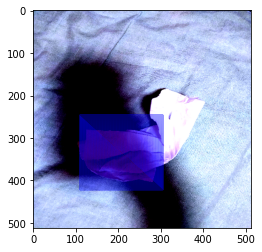

In [ ]:
plot_img(img.cpu(), boxes, masks, labels, colors)

In [ ]:
!nvidia-smi

Sun Nov 21 16:09:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    58W / 149W |  11230MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------